# Gingivitis Classifier model

## Setting up the Environment and Dependencies

Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set file paths

In [2]:
model1_file_path = '/content/drive/MyDrive/Final_Year/Implementation/Teeth_detection/Cache/runs/detect/train/weights/best.pt'
model2_file_path = '/content/drive/MyDrive/Final_Year/Implementation/Gingivititis_level_prediction/Weight/gingivititis_classification_weight_final.hdf5'

Import libraries

In [3]:
!pip install fastapi
!pip install nest-asyncio
!pip install pyngrok
!pip install uvicorn
!pip install flask_ngrok
!pip install pydantic
!pip install geopandas
!pip install turfpy
!pip install ultralytics==8.0.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for turfpy: filename=turfpy-0.0.7-py3-none-any.whl size=39097 sha256=314b8e9fe18406045039ac20f7c915898b2546f53b7d00a1807cab9868ceb9e0
  Stored in directory: /root/.cache/pip/wheels/7a/05/e3/11a72686a770c2117b4465d02abd5f25f8d94c2f823ca0c112
Successfully built turfpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 8.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached 

In [4]:
import json
import urllib
import os
import torch
import yaml

import cv2
import keras.utils as utils_image
import numpy as np
import uvicorn
import urllib.request
from typing import List, Dict, Optional
from tabulate import tabulate

from flask import Flask, flash, redirect, render_template, request, url_for
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename

import tensorflow as tf
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras import Model
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image

from pydantic import BaseModel

from pyngrok import ngrok

from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio

from google.colab import drive
from google.colab.patches import cv2_imshow

In [5]:
from ultralytics import YOLO

## Data preprocessing

In [6]:
from traitlets.traitlets import Any
class Teeth(BaseModel):
  location: int
  mask: Optional[object] = None
  left: int
  right: int
  top: int
  bottom: int
  area: int
  level: Optional[str] = None
  probability: Optional[str] = None
  health: Optional[int] = None

  def to_dict(self):
        return {
            'location': self.location,
            'left': self.left,
            'right': self.right,
            'top': self.top,
            'bottom': self.bottom,
            'area': self.area
        }

## Model preparation

Set up teeth idantify and gingivitis classification model s

In [7]:
model1 = YOLO(model1_file_path)

In [8]:
CLASSES = ['healthy', 'moderate', 'severe', 'mild']

In [9]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax", )
conv = irv2.layers[-20].output
conv = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
output = Flatten()(conv)
output = Dense(4, activation='softmax')(output)
model2 = Model(inputs=irv2.input, outputs=output)

model2.load_weights(model2_file_path)

225209952/225209952 [==============================] - 2s 0us/step


## Teeth Detection

In [10]:
def detect_teeth(image_array):
  original_image = cv2.imdecode(image_array, -1)
  image = cv2.imdecode(image_array, -1)
  thickness = 7

  results = model1.predict(source=image, conf=0.75)
  teeth_list = []

  for i in range(len(results[0].boxes.xyxy)):

    left = int((results[0].boxes.xyxy[i])[0].item())
    top = int((results[0].boxes.xyxy[i])[1].item())
    right= int((results[0].boxes.xyxy[i])[2].item())
    bottom = int((results[0].boxes.xyxy[i])[3].item())
    color = list(np.random.random(size=3) * 256)
    image = cv2.rectangle(image, (left, top), (right, bottom), color, thickness)

    # Add tooth to list
    teeth_list.append(Teeth(location=i, mask=results[0].boxes.xyxy[i], left=left, right=right, top=top, bottom=bottom, area=((right-left)*(bottom-top))))


  # Sort teeth_list by left position
  teeth_list = sorted(teeth_list, key=lambda t: t.left)

  # Resize image and display
  resized_image = cv2.resize(image, (400, 200))
  cv2_imshow(resized_image)

  # return image with the list of detected teeth
  return original_image, teeth_list

## Missing Teeth Identification

In [11]:
def identify_missing_teeth(result,img):

  new_toothlist = []
  thickness = 7
  p = lambda x : x/100

  for i in range(len(result)):
    result[i].location = len(new_toothlist)
    new_toothlist.append(result[i])

    if((i+1) < len(result)):
      teeth_1_width = result[i].right - result[i].left
      teeth_2_width = result[i+1].right- result[i+1].left
      distance = result[i+1].left - result[i].right

      if(teeth_1_width < distance):
        avarage_width = (teeth_1_width*p(90) +teeth_2_width*p(90))/2
        missing_teeths = int(distance/avarage_width)
        missing_teeth_width = int(distance/missing_teeths)
        start = result[i].right

        missing_teeth_top = int(max(result[i].top, result[i+1].top)+(result[i+1].top - result[i].top)/2)
        missing_teeth_bottom = int(max(result[i].bottom, result[i+1].bottom)+(result[i+1].bottom - result[i].bottom)/2)

        for c in range(missing_teeths):
          missing_teeth_left = int(start+(missing_teeth_width*c))
          missing_teeth_right = int(start+(missing_teeth_width*(c+1)))

          color = list(np.random.random(size=3) * 256)
          img = cv2.rectangle(img, (missing_teeth_left, missing_teeth_top), (missing_teeth_right, missing_teeth_bottom), color, thickness)

          new_toothlist.append(Teeth(location=len(new_toothlist), mask="",left=(start+(missing_teeth_width*(c))), right=(start+(missing_teeth_width*(c+1))),top=missing_teeth_top, bottom=missing_teeth_bottom, area=((missing_teeth_right-missing_teeth_left)*(missing_teeth_bottom-missing_teeth_top))))

  resized_image = cv2.resize(img, (400, 200))
  cv2_imshow(resized_image)
  return new_toothlist


## Dental Diseases Classification

Resize image

In [12]:
def resize_and_pad(image, target_size):
    img = 0

    width, height = image.size
    if width == height:
        img = image
    elif width > height:
        result = Image.new(image.mode, (width, width), (255, 255, 255))
        result.paste(image, (0, (width - height) // 2))
        img= result
    else:
        result = Image.new(image.mode, (height, height), (255, 255, 255))
        result.paste(image, ((height - width) // 2, 0))
        img = result

    img = img.resize((299, 299))
    # img.show()

    return img

In [13]:
def add_presanatage(num):
    result = num + ((num/100)*5)
    return result

def remove_presanatage(num):
    result = num - ((num/100)*5)
    return result

Crop parts in image

In [14]:
def crop_and_pad_image(arr, teeth_location):
    img = cv2.imdecode(arr, -1)
    h, w, c = img.shape

    # You may need to convert the color.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    # Convert the image to RGB mode and resize
    img = img.convert('RGB')

    teeth_hight = (teeth_location.bottom - teeth_location.top)
    teeth_weith = (teeth_location.right - teeth_location.left)
    middle = teeth_location.top + (teeth_hight/4)
    best_top = remove_presanatage(middle - teeth_hight)
    best_top2 = remove_presanatage(middle - teeth_weith)

    if(best_top>best_top2):
      best_top = best_top2

    if (best_top < 0):
      best_top = 0

    bestweith = ((teeth_weith/100)*5)

    # img2 = img.crop((teeth_location.left, h, teeth_location.right, 0))
    img = img.crop(((teeth_location.left-bestweith), best_top, (teeth_location.right+bestweith), add_presanatage(middle)))
    img = resize_and_pad(img, (299, 299))

    return img

Diseases classification

In [15]:
def get_detection_report(predictions):

    predictions = predictions.tolist()
    predictions = [[round(elem * 100, 2) for elem in sublist] for sublist in predictions]
    predictions = [[float(elem) for elem in sublist] for sublist in predictions]
    predictions = predictions[0]
    result = dict(zip(CLASSES, predictions))
    result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    final_result_report = dict(result)

    return final_result_report

In [16]:
def diseases_Classification(arr, result):
    output = []

    for tooth in result:
        tooth_dict = {}

        try:
          spect_img = crop_and_pad_image(arr, tooth)

          img_array = utils_image.img_to_array(spect_img)
          img_batch = np.expand_dims(img_array, axis=0)
          normalized_image = np.vstack([img_batch]) / 255.0
          prediction_results = model2.predict(normalized_image)

          classification_report = get_detection_report(prediction_results)

          probability = max(classification_report.values())
          predicted_class = max(classification_report, key=lambda k: classification_report[k])
          health = (min(max(probability, 0), 100) / 4)

          health_adjustments = {
            "healthy": 75,
            "mild": 50,
            "moderate": 25,
            "severe": 0,
          }

          health += health_adjustments.get(predicted_class, 0)
          health = int(health)

        except IndexError as e:
          print(e)

        except Exception as e:
          print(e)

        # Add the class prediction to the tooth dictionary
        tooth.level = predicted_class
        tooth.probability = str(probability)
        tooth.health = health
        tooth.mask = ""

        output.append(tooth)

    return output

## Analysis and Diagnosis

Diagnose

In [17]:
def diagnose_teeth(images):
    responce = []

    for image in images:
      teeth_result = []

      req = urllib.request.urlopen(image["image"])
      image_array = np.asarray(bytearray(req.read()), dtype=np.uint8)

      print("\n1) Load image and teeth detaction\n")
      img, result = detect_teeth(image_array)

      print("\n2) Identify missing teeth\n")
      result = identify_missing_teeth(result,img)

      print("\n3) Diseases classification\n")
      result = diseases_Classification(image_array, result)

      headers = ['Location', 'Left', 'Right', 'Top', 'Bottom', 'Area', 'Level', 'Probability', 'health']
      table = []
      for teeth in result:
          table.append([teeth.location, teeth.left, teeth.right, teeth.top, teeth.bottom, teeth.area, teeth.level, teeth.probability, teeth.health])
      print(tabulate(table, headers=headers, tablefmt='fancy_grid'))

      predict_result_output = []

      for teeth in result:
        predict_result_output.append(teeth.health)

      teeth_result.append(result)
      teeth_result.append(predict_result_output)
      responce.append(teeth_result)

    return responce

Test sample data

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)



1) Load image and teeth detaction



Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded


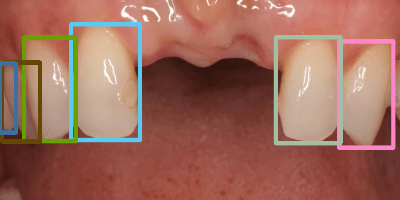


2) Identify missing teeth



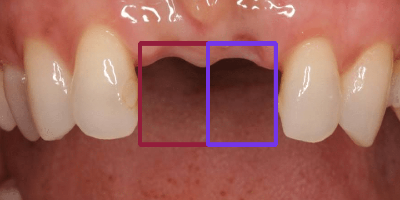


3) Diseases classification

1/1 [==============================] - 0s 62ms/step
╒════════════╤════════╤═════════╤═══════╤══════════╤════════╤══════════╤═══════════════╤══════════╕
│   Location │   Left │   Right │   Top │   Bottom │   Area │ Level    │   Probability │   health │
╞════════════╪════════╪═════════╪═══════╪══════════╪════════╪══════════╪═══════════════╪══════════╡
│          0 │      0 │      35 │   122 │      255 │   4655 │ moderate │        100    │       50 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          1 │      4 │      88 │   120 │      272 │  12768 │ moderate │         99.95 │       49 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          2 │     52 │     166 │    72 │      271 │  22686 │ healthy  │         99.62 │       99 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          3 │    1

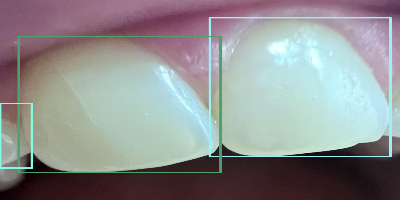


2) Identify missing teeth



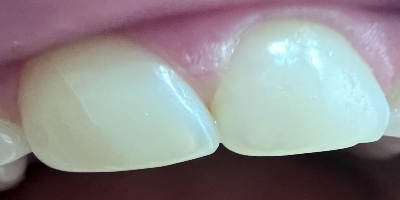


3) Diseases classification

1/1 [==============================] - 0s 70ms/step
╒════════════╤════════╤═════════╤═══════╤══════════╤════════╤══════════╤═══════════════╤══════════╕
│   Location │   Left │   Right │   Top │   Bottom │   Area │ Level    │   Probability │   health │
╞════════════╪════════╪═════════╪═══════╪══════════╪════════╪══════════╪═══════════════╪══════════╡
│          0 │      0 │     109 │   637 │     1037 │  43600 │ moderate │         99.82 │       49 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          1 │     64 │     757 │   225 │     1064 │ 581427 │ healthy  │         98.07 │       99 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          2 │    720 │    1340 │   109 │      965 │ 530720 │ healthy  │         99.65 │       99 │
╘════════════╧════════╧═════════╧═══════╧══════════╧════════╧══════════╧═══════════════╧══════════╛

1) Load image and 

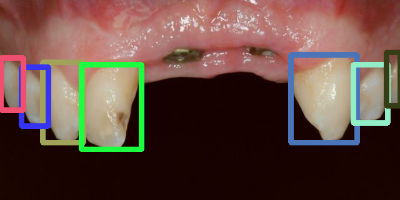


2) Identify missing teeth



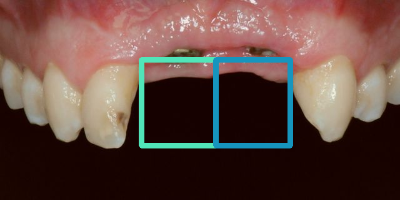


3) Diseases classification

1/1 [==============================] - 0s 72ms/step
╒════════════╤════════╤═════════╤═══════╤══════════╤════════╤══════════╤═══════════════╤══════════╕
│   Location │   Left │   Right │   Top │   Bottom │   Area │ Level    │   Probability │   health │
╞════════════╪════════╪═════════╪═══════╪══════════╪════════╪══════════╪═══════════════╪══════════╡
│          0 │      1 │      37 │    94 │      179 │   3060 │ moderate │        100    │       50 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          1 │     34 │      77 │   109 │      205 │   4128 │ moderate │         94.8  │       48 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          2 │     68 │     133 │   101 │      232 │   8515 │ moderate │         96.1  │       49 │
├────────────┼────────┼─────────┼───────┼──────────┼────────┼──────────┼───────────────┼──────────┤
│          3 │    1

In [18]:
data = [
    {
        "image" : "https://dentalsociety.com.au/wp-content/uploads/2020/11/implant-slider-before.png",
        "name" : "image1"
    },
    {
        "image" : "https://preview.redd.it/hi-both-my-two-front-teeth-have-these-weird-cracks-from-the-v0-59rhagti3vm81.jpg?auto=webp&s=d38cacfa172bc5c093dea2d69dfd21dc42abd3b1",
        "name" : "image1"
    },
    {
        "image" : "https://lirp.cdn-website.com/76d7f6bd/dms3rep/multi/opt/4-Implants+bridge+1C+1280-640w.jpg",
        "name" : "image2"
    }
]

result = diagnose_teeth(data)

## Developing a REST API

In [19]:
!ngrok authtoken 2NkLXcraLU3z71F8naFdza3cDDT_34DvFc773F7EUxHHNShEi

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [20]:
app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

class Item(BaseModel):
   url: str

class Items(BaseModel):
   data: list

@app.get('/')
async def root():
  return "Server up and running"

@app.post("/diagnose")
async def diagnose(item: Items):
  teeth = diagnose_teeth(item.data)
  return teeth

In [ ]:
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [1683]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://18f2-34-16-164-138.ngrok-free.app
INFO:     2402:d000:a400:4d6f:e8a3:2102:42d9:8a28:0 - "GET / HTTP/1.1" 200 OK
INFO:     2402:d000:a400:4d6f:e8a3:2102:42d9:8a28:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
